<h3> Loading in and cleaning data

In [143]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cities = pd.read_csv('./data/cities.csv')
routes = pd.read_csv('./data/routes.csv')
visitors = pd.read_csv('./data/visitors.tsv', delimiter="\t" ,encoding='utf-16') #note tab delimitting

In [3]:
cities.shape, routes.shape, visitors.shape

((862, 4), (98, 3), (3196, 4))

routes pre-processing

In [4]:
routes.head(2)

,"“route_url_form""",num_operators,num_departures
0,"Almafuerte,Cordoba,Argentina/Rosario,SantaFe,A...",2,4
1,"BahiaBlanca,BuenosAires,Argentina/BuenosAires,...",7,230


In [5]:
routes.columns=["route_url", "num_operators", "num_departures"]

In [6]:
#take a look at routes variable
for i in routes['route_url'][0:10]:
    print(i)

Almafuerte,Cordoba,Argentina/Rosario,SantaFe,Argentina
BahiaBlanca,BuenosAires,Argentina/BuenosAires,BuenosAiresFD,Argentina
BuenosAires,BuenosAiresFD,Argentina/Asuncion,Asuncion,Paraguay
BuenosAires,BuenosAiresFD,Argentina/BahiaBlanca,BuenosAires,Argentina
BuenosAires,BuenosAiresFD,Argentina/BalnearioSanClementedelTuyu,BuenosAires,Argentina
BuenosAires,BuenosAiresFD,Argentina/ComodoroRivadavia,Chubut,Argentina
BuenosAires,BuenosAiresFD,Argentina/Concordia,Kansas,UnitedStates
BuenosAires,BuenosAiresFD,Argentina/Corrientes,Corrientes,Argentina
BuenosAires,BuenosAiresFD,Argentina/Formosa,Formosa,Argentina
BuenosAires,BuenosAiresFD,Argentina/LaRioja,LaRioja,Argentina


In [7]:
#use regex to split into 6 columns
import re
def split_url(route):
    finder = re.compile("([A-Z]\w+)([,/&]|$)") #word that starts with capital letter, followed by comma, / or end of string
    feat_tup = tuple([e[0] for e in finder.findall(route)])
    if(len(feat_tup)>6): #added this to deal with longer urls
        return feat_tup[:6]
    return feat_tup

In [8]:
routes['city1'], routes['region1'], routes['country1'], routes['city2'], routes['region2'], routes['country2']=zip(*routes['route_url'].apply(split_url))

In [9]:
#routes have a direction
routes.loc[((routes.city1=='BuenosAires')& (routes.city2=='Rosario'))|(routes.city1=='Rosario')&(routes.city2=='BuenosAires')]

,route_url,num_operators,num_departures,city1,region1,country1,city2,region2,country2
24,"BuenosAires,BuenosAiresFD,Argentina/Rosario,Sa...",13,439,BuenosAires,BuenosAiresFD,Argentina,Rosario,SantaFe,Argentina
68,"Rosario,SantaFe,Argentina/BuenosAires,BuenosAi...",13,544,Rosario,SantaFe,Argentina,BuenosAires,BuenosAiresFD,Argentina


In [10]:
#not all routes are 2 way
len(routes.city1.unique()),len(routes.city2.unique())

(28, 49)

In [11]:
#not sure there's an argentina - spain bus route. I'll remove these 2.
routes.country2.value_counts()

Argentina       85
Uruguay          3
UnitedStates     2
Brazil           2
Chile            2
Spain            2
Paraguay         1
Peru             1
Name: country2, dtype: int64

In [12]:
routes=routes.loc[routes.country2 != 'Spain']

In [13]:
routes.country1.value_counts()

Argentina    96
Name: country1, dtype: int64

In [14]:
routes.head(3)

,route_url,num_operators,num_departures,city1,region1,country1,city2,region2,country2
0,"Almafuerte,Cordoba,Argentina/Rosario,SantaFe,A...",2,4,Almafuerte,Cordoba,Argentina,Rosario,SantaFe,Argentina
1,"BahiaBlanca,BuenosAires,Argentina/BuenosAires,...",7,230,BahiaBlanca,BuenosAires,Argentina,BuenosAires,BuenosAiresFD,Argentina
2,"BuenosAires,BuenosAiresFD,Argentina/Asuncion,A...",1,24,BuenosAires,BuenosAiresFD,Argentina,Asuncion,Asuncion,Paraguay


cities preprocessing

In [15]:
cities.head(3)

,"“city_url_form""",lat,lon,population
0,"Galvez,ProvinciadeSantaFe,Argentina",-32.02927,-61.22103,18374.0
1,"VillaMercedes,SanLuis,Argentina",-33.67571,-65.45783,96781.0
2,"Selva,ProvinciadeSantiagodelEstero,Argentina",-29.76776,-62.04770,0.0


In [16]:
cities.columns=['city_url', 'lat', 'lon', 'population']

In [17]:
cities['city'],cities['region'],cities['country']=zip(*cities['city_url'].apply(split_url))

In [18]:
#a lot of NaNs in population. To be consistent, I'll encode them all as O. Roughly half are nan. Not sure if this is useful.
cities.population.replace(np.nan, value=0, inplace=True)
sum(cities.population==0),len(cities)

In [20]:
cities.head(3)

,city_url,lat,lon,population,city,region,country
0,"Galvez,ProvinciadeSantaFe,Argentina",-32.02927,-61.22103,18374.0,Galvez,ProvinciadeSantaFe,Argentina
1,"VillaMercedes,SanLuis,Argentina",-33.67571,-65.45783,96781.0,VillaMercedes,SanLuis,Argentina
2,"Selva,ProvinciadeSantiagodelEstero,Argentina",-29.76776,-62.04770,0.0,Selva,ProvinciadeSantiagodelEstero,Argentina


visitors preprocessing

In [21]:
visitors.head(3)

,page_language,route_url_form,user_country,num_visitors
0,de,"BahiaBlanca,BuenosAires,Argentina/Cordoba,Cord...",Switzerland,2
1,de,"BuenosAires,BuenosAiresFD,Argentina/Asuncion,A...",Argentina,7
2,de,"BuenosAires,BuenosAiresFD,Argentina/Asuncion,A...",Austria,7


In [22]:
visitors.columns=['language', 'route_url', 'user_country', 'num_visitors']

In [23]:
visitors['city1'], visitors['region1'], visitors['country1'], visitors['city2'], visitors['region2'], visitors['country2']=zip(*visitors['route_url'].apply(split_url))

In [24]:
#there are malformed languages. Replace these with last 2 chars
print(visitors.language.value_counts()[-5:])
visitors.language = visitors.language.str.slice(start=-2)

l?sa=t&rct=j&q=&esrc=s&source=web&cd=5&ved=0CGgQFjAE&url=http://www.busbud.com/pt                     1
l?sa=t&rct=j&q=&esrc=s&frm=1&source=web&cd=9&ved=0CIoBEBYwCA&url=http://www.busbud.com/en             1
l?sa=t&rct=j&q=mendoza buenos aires bus&source=web&cd=2&ved=0CFgQFjAB&url=http://www.busbud.com/de    1
l?sa=t&rct=j&q=&esrc=s&source=web&cd=4&ved=0CEsQFjAD&url=http://www.busbud.com/es                     1
l?sa=t&rct=j&q=&esrc=s&frm=1&source=web&cd=3&ved=0CE8QFjAC&url=http://www.busbud.com/fr               1
Name: language, dtype: int64


In [25]:
visitors.head(3)

,language,route_url,user_country,num_visitors,city1,region1,country1,city2,region2,country2
0,de,"BahiaBlanca,BuenosAires,Argentina/Cordoba,Cord...",Switzerland,2,BahiaBlanca,BuenosAires,Argentina,Cordoba,Cordoba,Argentina
1,de,"BuenosAires,BuenosAiresFD,Argentina/Asuncion,A...",Argentina,7,BuenosAires,BuenosAiresFD,Argentina,Asuncion,Asuncion,Paraguay
2,de,"BuenosAires,BuenosAiresFD,Argentina/Asuncion,A...",Austria,7,BuenosAires,BuenosAiresFD,Argentina,Asuncion,Asuncion,Paraguay


<h3> Feature engineering

I want to know the distance of each route. Because they're lat and lon, the calculation is a little tricky. I'm using some code from github for the calculation function. I apply this for both the routes and the visitors dataframes.

In [41]:
#get lat and lon for cities in routes. I assume the string of each city + region is unique
cities_merge1=cities[['city','region', 'lat', 'lon']]
cities_merge1.columns=['city1','region1', 'lat1', 'lon1']
cities_merge2=cities[['city','region', 'lat', 'lon']]
cities_merge2.columns=['city2','region2', 'lat2', 'lon2']
_routes_merge1 = routes.merge(cities_merge1, on=['city1','region1'], how='left')
routes_distance = _routes_merge1.merge(cities_merge2, on=['city2','region2'], how='left')
#should have same number of examples.
routes_distance.shape, routes.shape

((96, 14), (96, 10))

In [46]:
#1/10 don't merge
sum(routes_distance.lat2.isnull()|routes_distance.lat1.isnull())

11

In [42]:
#do the same for cities in visitors.
_visitors_merge1 = visitors.merge(cities_merge1, on=['city1', 'region1'], how='left')
visitors_distance = _visitors_merge1.merge(cities_merge2, on=['city2', 'region2'], how='left')
visitors_distance.shape, visitors.shape

((3196, 14), (3196, 10))

In [45]:
#1/3 don't merge.
sum(visitors_distance.lat2.isnull()|visitors_distance.lat1.isnull())

984

In [47]:
from math import sin, cos, sqrt, atan2, radians

def lat_lon_to_distance(lat1, lon1, lat2, lon2):
    R = 6373.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [48]:
routes_distance['distance'] = routes_distance.apply(lambda x: lat_lon_to_distance(x['lon1'], x['lat1'], x['lon2'], x['lat2']), axis=1)
routes['distance']=routes_distance['distance']
routes_distance['distance'].max(), routes_distance['distance'].min()

(1628.6759366459958, 62.530728054857235)

In [49]:
visitors_distance['distance'] = visitors_distance.apply(lambda x: lat_lon_to_distance(x['lon1'], x['lat1'], x['lon2'], x['lat2']), axis=1)
visitors['distance']=visitors_distance['distance']
visitors_distance['distance'].max(), visitors_distance['distance'].min()

(2284.3240176245763, 7.7118478501413348)

In [50]:
#I checked this outlier on google maps and it seems ok. 
visitors_distance.loc[visitors_distance.distance == visitors_distance['distance'].min()]

,language,route_url,user_country,num_visitors,city1,region1,country1,city2,region2,country2,lat1,lon1,lat2,lon2,distance
1678,es,"Cordoba,Cordoba,Argentina/JuarezCelman,Cordoba...",Argentina,2,Cordoba,Cordoba,Argentina,JuarezCelman,Cordoba,Argentina,-31.4135,-64.18105,-31.25809,-64.16611,7.711848


In [134]:
#get number of route departures and operators
_visitors2 = visitors.merge(routes[['route_url','num_operators','num_departures']], on='route_url', how='left')
visitors = _visitors2

In [135]:
visitors

,language,route_url,user_country,num_visitors,city1,region1,country1,city2,region2,country2,distance,num_operators,num_departures
0,de,"BahiaBlanca,BuenosAires,Argentina/Cordoba,Cord...",Switzerland,2,BahiaBlanca,BuenosAires,Argentina,Cordoba,Cordoba,Argentina,422.816169,NaN,NaN
1,de,"BuenosAires,BuenosAiresFD,Argentina/Asuncion,A...",Argentina,7,BuenosAires,BuenosAiresFD,Argentina,Asuncion,Asuncion,Paraguay,NaN,1.0,24.0
2,de,"BuenosAires,BuenosAiresFD,Argentina/Asuncion,A...",Austria,7,BuenosAires,BuenosAiresFD,Argentina,Asuncion,Asuncion,Paraguay,NaN,1.0,24.0
3,de,"BuenosAires,BuenosAiresFD,Argentina/Asuncion,A...",Brazil,2,BuenosAires,BuenosAiresFD,Argentina,Asuncion,Asuncion,Paraguay,NaN,1.0,24.0
4,de,"BuenosAires,BuenosAiresFD,Argentina/Asuncion,A...",Chile,2,BuenosAires,BuenosAiresFD,Argentina,Asuncion,Asuncion,Paraguay,NaN,1.0,24.0
5,de,"BuenosAires,BuenosAiresFD,Argentina/Asuncion,A...",Germany,42,BuenosAires,BuenosAiresFD,Argentina,Asuncion,Asuncion,Paraguay,NaN,1.0,24.0
6,de,"BuenosAires,BuenosAiresFD,Argentina/Asuncion,A...",Mexico,2,BuenosAires,BuenosAiresFD,Argentina,Asuncion,Asuncion,Paraguay,NaN,1.0,24.0
7,de,"BuenosAires,BuenosAiresFD,Argentina/Asuncion,A...",Paraguay,7,BuenosAires,BuenosAiresFD,Argentina,Asuncion,Asuncion,Paraguay,NaN,1.0,24.0
8,de,"BuenosAires,BuenosAiresFD,Argentina/Asuncion,A...",Spain,2,BuenosAires,BuenosAiresFD,Argentina,Asuncion,Asuncion,Paraguay,NaN,1.0,24.0
9,de,"BuenosAires,BuenosAiresFD,Argentina/Asuncion,A...",Switzerland,5,BuenosAires,BuenosAiresFD,Argentina,Asuncion,Asuncion,Paraguay,NaN,1.0,24.0


<h3> Data exploration

What is the realistic action space for the company, using this data?
1. Target a specific type of customer (geographic region, language, website search behaviour)
2. Promote a particular route to a specific type of customer (how? build a simple recommendation engine - people from this place often go to this other place next, OR promote a route that leads them to middle of nowhere)
3. Integrate more operators on certain routes
4. Greater development or translation in a new language

What information do I need to decide on where to expend efforts in this action space?
- where are the routes coming from and going to? Does this change by customer type? 
- how are the operators distributed? How are they distributed by customer?
- I assume we make more money on longer routes. What are the characteristics of longer routes? What are the trends in the customers?
- how are users distributed per country? Which ones have highest value - what metrics can I use to tease out highest value?

<h4> Univariate analysis

Routes:
- all routes are leaving from argentina. 1/3 from BA, 1/4 to BA. 
- 90% of the routes arrive in an Argentinian destination.

In [90]:
#categorical variables in routes
for c in [a for a in routes.columns if a not in ['route_url', 'num_op', 'num_dep', 'distance']]:
    print(c, '\n', routes[c].value_counts())

num_operators 
 3     15
2     14
1     13
7     10
5     10
6      9
4      9
11     3
10     3
9      3
14     2
13     2
15     1
12     1
8      1
Name: num_operators, dtype: int64
num_departures 
 8      5
14     4
32     3
4      3
83     3
16     3
52     2
144    2
1      2
2      2
12     2
24     2
10     2
56     2
230    2
34     2
40     1
246    1
166    1
157    1
41     1
42     1
43     1
30     1
151    1
412    1
26     1
49     1
22     1
131    1
      ..
118    1
115    1
112    1
111    1
237    1
236    1
488    1
103    1
544    1
53     1
28     1
221    1
136    1
215    1
51     1
104    1
75     1
202    1
200    1
70     1
288    1
68     1
320    1
60     1
186    1
57     1
439    1
55     1
126    1
128    1
Name: num_departures, Length: 71, dtype: int64
city1 
 BuenosAires             39
Rosario                 13
Mendoza                  8
PuertoIguazu             4
SanCarlosdeBariloche     4
Salta                    3
Corrientes               3
SanJu

Visitors. 
- We have a natural segmentation: Argentina vs. South Americans vs. Others.
- A large proportion of the site visitors are in portuguese - aka mostly from Brazil

In [53]:
visitors.groupby('user_country').agg('sum')['num_visitors'].sort_values(ascending=False)[:10]

user_country
Brazil           18723
Argentina        14118
France            3393
Chile             2804
Germany           2433
Italy             1928
Uruguay           1291
United States     1290
Spain              996
Switzerland        842
Name: num_visitors, dtype: int64

In [54]:
visitors.groupby('language').agg('sum')['num_visitors'].sort_values(ascending=False)[:10]

language
pt    19718
es    15336
fr     6381
en     5526
de     5083
it     2421
nl      596
sv      121
pl       83
tr       26
Name: num_visitors, dtype: int64

Difference in distribution between routes available and the ones our customers are interested in. 
- Our visitors overwhelmingly leave from Buenos Aires, to go... all over the place
- Cordoba and Santiago are particularly popular with site visitors, even though there are less buses that go there, proportionally. 
- Rosario is very low: it's the 3rd more populous city in Argentina, but eh. Maybe city population isn't so useful after all.
- Long tail for visitor arrivals - more evenly distributed. Many go to Santiago in Chile, Montevideo in Uruguay...

In [237]:
import operator
def get_top_routes(df,agg_col, top=5, differentiate=False,printer=True,graph=False,title=""):
    #function to get the top routes given some subset of the routes df. Can differentiate, or not, between arrivals and departures.
    #can print or graph the results if you do differentiate between the two.
    
    #get counts for departure and destination city
    count1=df.groupby('city1').agg('sum')[agg_col].sort_values(ascending=False).to_dict()
    count2=df.groupby('city2').agg('sum')[agg_col].sort_values(ascending=False).to_dict()
    svc=sum(count1.values()) #note: I am getting the % of routes these cities are in.
    
    if(not differentiate):
        #merge 1 and 2
        total_counts = { k: count1.get(k, 0) + count2.get(k, 0) for k in set(count1) | set(count2) }
        total_counts_top = sorted(total_counts.items(), key=operator.itemgetter(1), reverse=True)[:top]

        #print total
        print('Top '+str(top)+' routes, (units=% of buses that leave or go to this place. Weighted by',str(agg_col)+')')
        for i in total_counts_top:
            print(i[0], round(i[1]/svc,3),'%')
            
        if(graph==True):
            y=[i[1] for i in total_counts_top]
            x=range(len(total_counts_top))
            plt.bar(x,y)
            plt.title(title)
    else:
        count1_top = sorted(count1.items(), key=operator.itemgetter(1), reverse=True)[:top]
        count2_top = sorted(count2.items(), key=operator.itemgetter(1), reverse=True)[:top]
        
        if(printer==True):
            print('Top '+str(top)+' departures, (units=% of buses that leave from this place. Weighted by',str(agg_col)+')')
            for i in count1_top:
                print(i[0], round(i[1]/svc,3),'%')
            print('\n')

            #print arrivals
            print('Top '+str(top)+' arrivals, (units=% of buses that go to this place. Weighted by',str(agg_col)+')')
            for i in count2_top:
                print(i[0], round(i[1]/svc,3),'%')
    
        if(graph==True):
            fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,4))
            y=[i[1]/svc for i in count1_top]
            x=range(1,len(count1_top)+1)
            ax[0].bar(x,y)
            ticks=[i[0] for i in count1_top]
            ax[0].set_xticks(range(1,1+len(x)))
            ax[0].set_xticklabels(ticks, rotation=45)
            ax[0].set_title(title+', Departures top'+str(top))
            ax[0].set_ylabel('% buses that leave from here')
            ax[0].set_ylim([0, 1])
            
            y=[i[1]/svc for i in count2_top]
            x=range(len(count2_top))
            ax[1].bar(x,y)
            ax[1].set_title(title+', Arrivals top'+str(top))
            ax[1].set_ylabel('% buses that arrive here')
            ticks=[i[0] for i in count2_top]
            ax[1].set_xticks(range(len(x)))
            ax[1].set_xticklabels(ticks, rotation=45)
            ax[1].set_ylim([0, 1])


Top 10 departures, (units=% of buses that leave from this place. Weighted by num_visitors)
BuenosAires 0.795 %
Cordoba 0.155 %
Salta 0.013 %
PuertoIguazu 0.011 %
Mendoza 0.003 %
Posadas 0.002 %
Rosario 0.002 %
Parana 0.002 %
RioCuarto 0.001 %
LaPaz 0.001 %


Top 10 arrivals, (units=% of buses that go to this place. Weighted by num_visitors)
Santiago 0.156 %
Cordoba 0.101 %
Mendoza 0.1 %
Montevideo 0.076 %
PuertoIguazu 0.074 %
Rosario 0.056 %
SanCarlosdeBariloche 0.055 %
MardelPlata 0.047 %
RiodeJaneiro 0.047 %
Salta 0.036 %


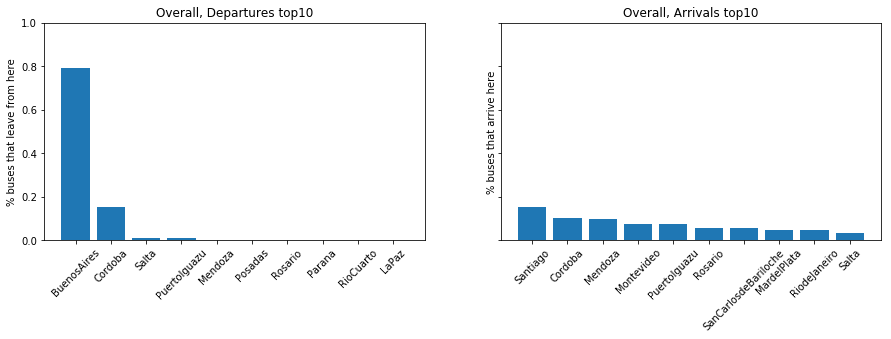

In [238]:
get_top_routes(visitors, 'num_visitors', top=10, differentiate=True, graph=True, title="Overall")

In [101]:
get_top_routes(routes, 'num_departures', top=10, differentiate=True)

Top 10 departures, (units=% of buses that leave from this place. Weighted by num_departures)
BuenosAires 0.524 %
Rosario 0.142 %
MardelPlata 0.05 %
Mendoza 0.034 %
Cordoba 0.029 %
SanLuis 0.025 %
BahiaBlanca 0.024 %
Posadas 0.021 %
PuertoIguazu 0.02 %
SanJuan 0.02 %


Top 10 arrivals, (units=% of buses that go to this place. Weighted by num_departures)
BuenosAires 0.291 %
Rosario 0.091 %
Resistencia 0.054 %
BahiaBlanca 0.043 %
Mendoza 0.034 %
MardelPlata 0.033 %
PuertoIguazu 0.029 %
Montevideo 0.028 %
Cordoba 0.027 %
SanLuis 0.027 %


<h3> Visitor segmentation analysis: by originating geography </h3> <br>
Looking at the characteristics of customers in Argentina, outside of argentina, and in South America but not Argentina. I'm especially interested in the distances travelled, and the places they travel from/to. Here's what I found out:
- For Brazilians, a lot of them are travelling long distances within Argentina, but relatively few are leaving the country. There's many operators on average on their routes.
- For Argentinians, they are travelling short distances and staying in the country. They must be going to more remote places: there's few operators on average on their routes, and a lot of routes with no operators available.
- South Central Americans: I am hoping to target backpackers here. They change countries a whopping 40% of their routes! Their travels within Argentina seem to have shorter distances. Interesting consumer behaviour, 2 explanations: 1) a mix of locals and backpackers, locals don't need to travel huge distances and 2) backpackers travelling across south america have time to do more than 1 country, they can travel shorter distances to go to more cities.
- Rest: this group travels long distances in Argentina, and goes across the border often. But what is the closing ratio on these customers? These numbers might be artificially high.

In [183]:
brazil = visitors.loc[visitors.user_country == 'Brazil']
loosely_sc_am = ['Venezuela', 'Peru', 'Chile', 'Columbia','Cuba', 'Costa Rica', 'Ecuador','Mexico',
                 'Bolivia', 'Uruguay', 'Paraguay', 'Panama', 'Dominican Republic']
sc_america = visitors.loc[visitors.user_country.isin(loosely_sc_am)]
argentina = visitors.loc[visitors.user_country == 'Argentina']
rest = visitors.loc[~visitors.user_country.isin(loosely_sc_am+['Brazil', 'Argentina'])]

------------------------------ Analysis for:  brazil ------------------------------
n=18723 0.33862653958148703 


average distance within argentina: 571.497032745
Travelling across borders, no distance values: 0.249
Average number operators: 6.24184158522
Uncommon routes, no operators: 0.592
------------------------------ Analysis for:  south central america ------------------------------
n=6983 0.1262954187842506 


average distance within argentina: 264.213252204
Travelling across borders, no distance values: 0.386
Average number operators: 3.6126306745
Uncommon routes, no operators: 0.513
------------------------------ Analysis for:  argentina ------------------------------
n=14118 0.255339928740663 


average distance within argentina: 350.275784483
Travelling across borders, no distance values: 0.201
Average number operators: 3.18784530387
Uncommon routes, no operators: 0.683
------------------------------ Analysis for:  rest ------------------------------
n=15467 0.2797381128935

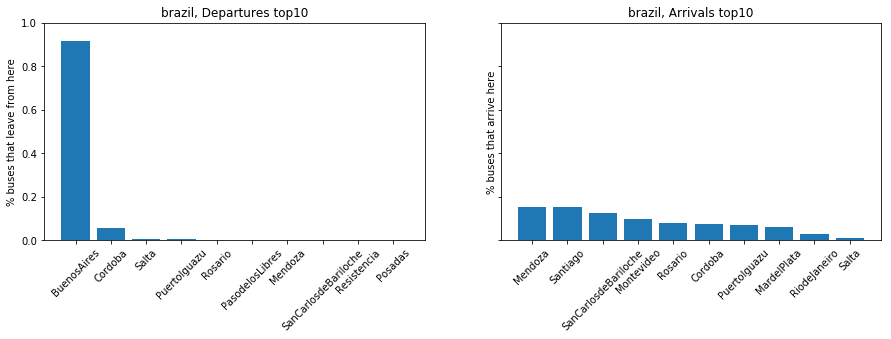

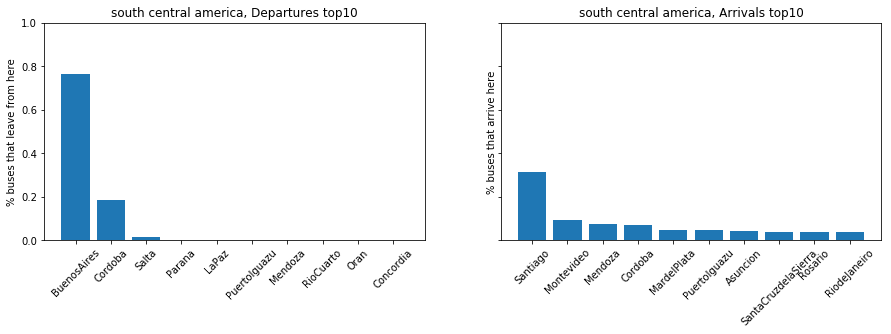

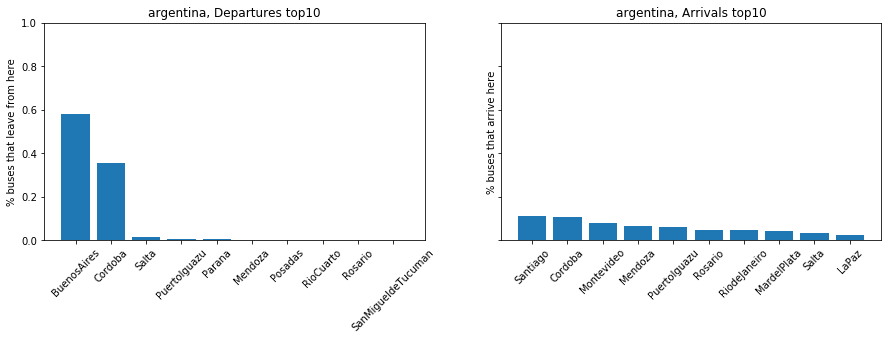

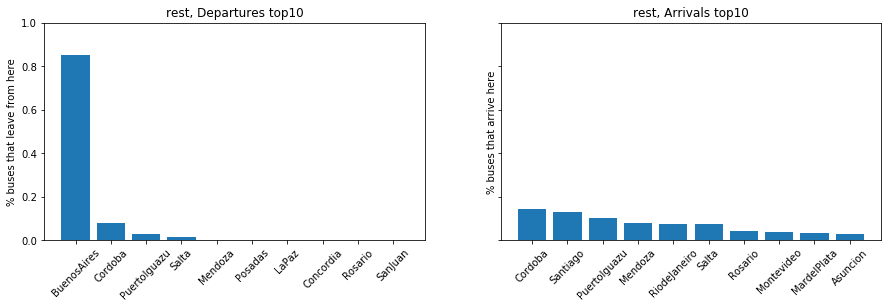

In [240]:
distance_avg={}
cross_border={}
avg_operators={}
no_operators={}

for mat,title in zip([brazil,sc_america, argentina, rest],['brazil', 'south central america','argentina', 'rest']):
    print('-'*30,'Analysis for: ', title, '-'*30)
    print('n='+str(mat.num_visitors.sum()),mat.num_visitors.sum()/visitors.num_visitors.sum(),'\n')
    
    #1: what are their top departure points, and their top arrivals
    get_top_routes(mat, 'num_visitors', top=10,differentiate=True, graph=True, printer=False, title=title)
    
    #2: what is the average bus trip distance
    num_visitors=mat.num_visitors.sum()
    null_mask_d = mat.distance.isnull()
    total_dist=np.multiply(mat[~null_mask_d].distance.values, mat[~null_mask_d].num_visitors.values).sum()
    print('\n'+'average distance within argentina:', total_dist/num_visitors)
    print('Travelling across borders, no distance values:',round(float(sum(null_mask_d))/float(len(mat)),3))
    
    #how many operators are on their routes, on average?
    null_mask_o = mat.num_operators.isnull()
    total_operators = np.multiply(mat[~null_mask_o].num_operators.values,mat[~null_mask_o].num_visitors.values).sum()
    print('Average number operators:',total_operators/num_visitors)
    print('Uncommon routes, no operators:',round(sum(null_mask_o)/float(len(mat)),3))
    
    #update the 4 dicts for later graphing
    avg_operators[title]=total_operators/num_visitors
    no_operators[title]=sum(null_mask_o)/len(mat)
    distance_avg[title]=total_dist/num_visitors
    cross_border[title]=sum(null_mask_d)/len(mat)

<h4> Additional graphing  </h4> <br>
- some really fascinating information here, showing the clear segmentation in the 4 user groups

In [ ]:
distance_avg={}
cross_border={}
avg_operators={}
no_operators={}

In [321]:
title_list = ['Average distances travelled within Argentina', 'Proportion of routes that cross a border', 'Average number of operators per route with existing operators',
           'Proportion of routes with no operators']
y_labels = ['km distance, birds flight', '% of routes, weighted by page visits', 'number of routes',
           '% of routes, weighted by page visits']

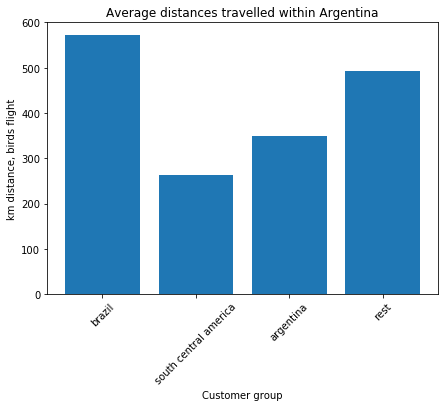

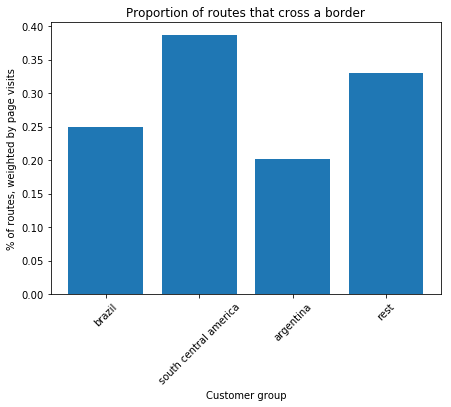

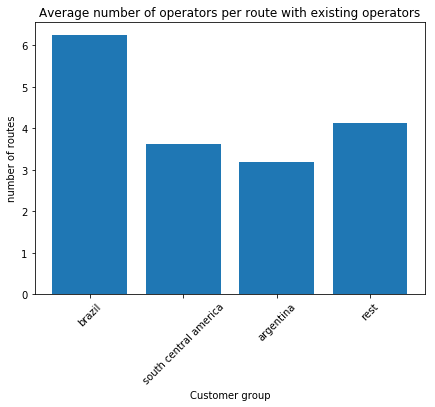

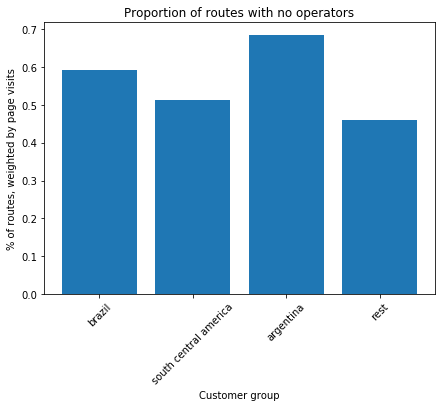

In [322]:
#distances graph
for dic,plot_title,y_label in zip([distance_avg, cross_border, avg_operators, no_operators],title_list,y_labels):
    fig,ax=plt.subplots(1,1, figsize=(7,5))
    y=[i[1] for i in dic.items()]
    x_labels=[i[0] for i in dic.items()]
    ax.bar(range(len(y)), y)
    ax.set_xticks(range(len(y)))
    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_title(plot_title)
    ax.set_ylabel(y_label)
    ax.set_xlabel('Customer group')
    plt.show()

In [258]:
# cross border
cross_border

{'argentina': 0.20091324200913241,
 'brazil': 0.24909747292418771,
 'rest': 0.33024118738404451,
 'south central america': 0.38604651162790699}

<h3> Quantifying the retention problem </h3>


In [305]:
#arrivals to departures ratios
arrival_per_city = visitors.groupby('city1').agg('sum')[['num_visitors']].reset_index()
departure_per_city = visitors.loc[visitors.country2=='Argentina'].groupby('city2').agg('sum')[['num_visitors']].reset_index()
arrival_departure_per_city = arrival_per_city.merge(departure_per_city, left_on='city1', right_on='city2')
arrival_departure_per_city['ad_ratio']=arrival_departure_per_city['num_visitors_x']/arrival_departure_per_city['num_visitors_y']

In [320]:
th=50
ad_per_city_th=arrival_departure_per_city.loc[arrival_departure_per_city.num_visitors_y>th]
ad_per_city_th.drop('city2', axis=1, inplace=True)
ad_per_city_th.columns=['city', 'visitors for departure', 'visitors for arrival', 'departure_arrival_ratio']
ad_per_city_th.sort_values(by='departure_arrival_ratio')

C:\Users\Baptiste\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,city,visitors for departure,visitors for arrival,departure_arrival_ratio
78,SantiagodelEstero,2,283,0.007067
76,SantaFe,6,703,0.008535
54,PuertoMadryn,6,603,0.009950
62,RioGallegos,4,292,0.013699
35,MardelPlata,38,2625,0.014476
93,VillaGesell,2,117,0.017094
65,SanCarlosdeBariloche,54,3045,0.017734
38,MinaClavero,4,213,0.018779
85,Trelew,6,258,0.023256
36,Mendoza,144,5551,0.025941


<h3> Visitor segmentation analysis: by arrival geography </h3> <br> 
- could dig deeper into this

In [121]:
out_of_country = visitors.loc[visitors.distance.isnull()]

In [127]:
out_of_country.groupby('country2').agg('sum')[['num_visitors']]

,num_visitors
country2,
Bolivia,1969
Brazil,3807
Chile,8903
Paraguay,1264
Peru,446
Spain,8
UnitedStates,10
Uruguay,4217


<h3> Simple Recommendation engine

In [293]:
cluster1=['Brazil']
cluster2=['Argentina']
cluster3=['Venezuela', 'Peru', 'Chile', 'Columbia','Cuba', 'Costa Rica', 'Ecuador','Mexico',
                 'Bolivia', 'Uruguay', 'Paraguay', 'Panama', 'Dominican Republic']
cluster4=[c for c in visitors.user_country.unique() if c not in (cluster3+cluster2+cluster1)]

def recommend_destination(visitors_df, destination, country):
    cluster=[]
    for c in [cluster1, cluster2, cluster3, cluster4]:
        cluster=c if country in c else cluster
    dep_destination = visitors_df.loc[(visitors_df.city1 == destination) & (visitors_df.user_country.isin(cluster))]
    
    #if not enough people in this cluster leaving from this destination, take all clusters
    if(sum(dep_destination.num_visitors.values)<20):
        dep_destination = visitors_df.loc[(visitors_df.city1 == destination)]
    
    #if still 
    
    dep_destination_no = dep_destination.groupby('city2').agg('sum')[['num_visitors']].sort_values(by='num_visitors', ascending=False)
    
    
    return dep_destination_no[:3]

In [325]:
recommend_destination(visitors, 'Mendoza', 'Venezuela')

,num_visitors
city2,
Santiago,54
BuenosAires,31
Montevideo,27
